## Load Libraries and CSV files

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
reviews=pd.read_csv('/Users/anna/Downloads/reviews.csv.gz',compression='gzip').dropna()
listings=pd.read_csv('/Users/anna/Downloads/listings (1).csv',error_bad_lines=False)
neighborhoods=pd.read_csv('/Users/anna/Downloads/neighbourhoods.csv',error_bad_lines=False)

inactive=listings.loc[listings.availability_365==365]
inactive.set_index('id',inplace=True)
listings.set_index('id',inplace=True)
new_listings=listings.drop(inactive.index,axis=0)

In [4]:
#check automated postings
autopost_1=reviews[reviews.comments.str.contains('The host canceled my reservation')]
autopost_2=reviews[reviews.comments.str.contains('This is an automated posting')]


#Conclusion by checking autopost_1 and autopost_2 dates: the automated posting changed in 2012. To make sure we include
#all automated cancellation postings, we create a new df "autopost" containing all automated postings.


autopost=pd.concat([autopost_1,autopost_2], axis=0).reset_index()
autopost.head()

,index,listing_id,id,date,reviewer_id,reviewer_name,comments
0,136,24328,221644,2011-04-10,315279,Craig,The host canceled my reservation 38 days befor...
1,431,26482,137001,2010-11-10,278167,Benjamin,The host canceled my reservation 52 days befor...
2,3639,47369,115767,2010-10-10,112795,Cédric,The host canceled my reservation the day befor...
3,3641,47369,129136,2010-10-28,251752,Mélanie,The host canceled my reservation 5 days before...
4,3646,47369,166592,2011-01-06,218191,Sharon,The host canceled my reservation the day befor...


In [8]:
canceled=autopost.listing_id.value_counts()
num_cancel=canceled.to_frame(name='cancellations')

new_listings['num_cancellations']=num_cancel
new_listings.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,num_cancellations
id,,,,,,,,,,,,,,,,
11551,Stylish and bright London apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,183,2018-08-22,1.65,2,290,NaN
13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,14,2018-06-17,0.13,3,362,1.0
15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,84,2019-04-22,0.74,1,155,NaN
17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52098,-0.14002,Entire home/apt,300,3,40,2019-04-20,0.40,13,230,NaN
24328,Battersea bedroom & office w parking shared ga...,41759,Joe,NaN,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,92,2016-09-07,0.89,1,332,3.0


In [13]:
booked=365-new_listings.availability_365
booked=booked.to_frame('days booked')
df=new_listings.merge(booked, how='left',left_index=True,right_index=True)
del df['neighbourhood_group']

In [14]:
def days_count(text):
    if 'the day before' in text:
        return 1
    else:
        return int(re.findall('\d+', text)[0])

total_days=pd.DataFrame(autopost.comments.apply(days_count))
auto=pd.merge(autopost,total_days,how='left',left_index=True,right_index=True)
auto.head()
 

,index,listing_id,id,date,reviewer_id,reviewer_name,comments_x,comments_y
0,136,24328,221644,2011-04-10,315279,Craig,The host canceled my reservation 38 days befor...,38
1,431,26482,137001,2010-11-10,278167,Benjamin,The host canceled my reservation 52 days befor...,52
2,3639,47369,115767,2010-10-10,112795,Cédric,The host canceled my reservation the day befor...,1
3,3641,47369,129136,2010-10-28,251752,Mélanie,The host canceled my reservation 5 days before...,5
4,3646,47369,166592,2011-01-06,218191,Sharon,The host canceled my reservation the day befor...,1


In [15]:
avg_days=pd.DataFrame(auto[['listing_id','comments_y']].groupby('listing_id')['comments_y'].apply(np.mean).apply(round))
avg_days.head()

,comments_y
listing_id,
13913,53
24328,33
25123,35
26482,21
36299,38


In [17]:
df['days_cancelled_avg']=avg_days

take_log = lambda x: np.log(x) if x>0 else 0

df['log_cancellations']=df.num_cancellations.apply(take_log)
df.head()


,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,num_cancellations,days booked,days_cancelled_avg,log_cancellations
id,,,,,,,,,,,,,,,,,,
11551,Stylish and bright London apartment in Zone 2,43039,Adriano,Lambeth,51.46225,-0.11732,Entire home/apt,88,2,183,2018-08-22,1.65,2,290,NaN,75,NaN,0.000000
13913,Holiday London DB Room Let-on going,54730,Alina,Islington,51.56802,-0.11121,Private room,65,1,14,2018-06-17,0.13,3,362,1.0,3,53.0,0.000000
15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,84,2019-04-22,0.74,1,155,NaN,210,NaN,0.000000
17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,Westminster,51.52098,-0.14002,Entire home/apt,300,3,40,2019-04-20,0.40,13,230,NaN,135,NaN,0.000000
24328,Battersea bedroom & office w parking shared ga...,41759,Joe,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,92,2016-09-07,0.89,1,332,3.0,33,33.0,1.098612


In [117]:
crime=pd.read_csv('/Users/anna/Downloads/crime rates.csv',error_bad_lines=False).dropna()

conv = lambda x: float(x.replace(',',''))

crime['Number_of_offences']=crime.Number_of_offences.apply(conv)

all_crimes=crime[crime['Offences']=='All recorded offences']

#crime includes 'Inner London','England & Wales','Met Police Area','Outer London' and 'Heathrow',
#which are not official London boroughs, so we drop these from our crime data

#the crime data doesn't include City of London (which is one of the neighbourhoods in our main data) 
#since it's not one of the 32 official London boroughs


all_crimes=all_crimes[all_crimes['Borough']!='Inner London']
all_crimes=all_crimes[all_crimes['Borough']!='England and Wales']
all_crimes=all_crimes[all_crimes['Borough']!='Met Police Area']
all_crimes=all_crimes[all_crimes['Borough']!='Outer London']
all_crimes=all_crimes[all_crimes['Borough']!='Heathrow']

all_crimes.head()

,Code,Borough,Year,Offences,Rate,Number_of_offences
0,E09000002,Barking and Dagenham,1999-00,All recorded offences,120.5,19567.0
1,E09000003,Barnet,1999-00,All recorded offences,98.0,30708.0
2,E09000004,Bexley,1999-00,All recorded offences,95.1,20680.0
3,E09000005,Brent,1999-00,All recorded offences,127.7,33253.0
4,E09000006,Bromley,1999-00,All recorded offences,89.8,26474.0


## Study Trends 

**Which neighborhoods have the most Airbnb listings?**

In [21]:
df_g=df.groupby('neighbourhood').sum()[['number_of_reviews','num_cancellations']]
df_g['total_listings']=df.neighbourhood.value_counts()
df_g=df_g.reset_index()


In [23]:
print('Top 5 Neighborhoods with the most Airbnb listings:')
df_g.sort_values(by=['total_listings'],ascending=False)[['neighbourhood','total_listings']][:5]

Top 5 Neighborhoods with the most Airbnb listings:


,neighbourhood,total_listings
32,Westminster,8757
29,Tower Hamlets,7591
11,Hackney,5862
5,Camden,5564
19,Kensington and Chelsea,5478


**Which neighborhoods have the most Airbnb reviews?**

Text(0.5, 1.0, 'Total Reviews per Neighborhood')

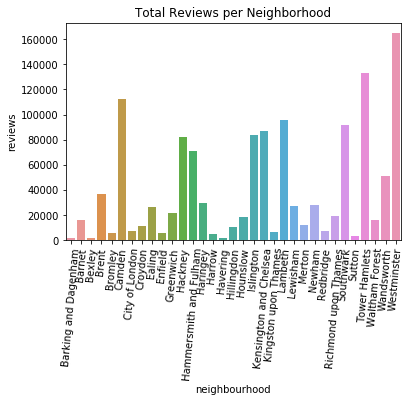

In [24]:
sns.barplot(x='neighbourhood',y='number_of_reviews',data=df_g)
plt.ylabel('reviews')
plt.xticks(rotation=85)
plt.title('Total Reviews per Neighborhood')

In [26]:
print('Top 5 Neighborhoods with the most reviews:')
df_g.sort_values(by=['number_of_reviews'],ascending=False)[['neighbourhood','number_of_reviews']][:5]

Top 5 Neighborhoods with the most reviews:


,neighbourhood,number_of_reviews
32,Westminster,165049
29,Tower Hamlets,133145
5,Camden,112457
21,Lambeth,96026
27,Southwark,92045


**Which Neighborhoods have the most Airbnb cancellations?**

Text(0.5, 1.0, 'Total Cancellations Per Neighbourhood')

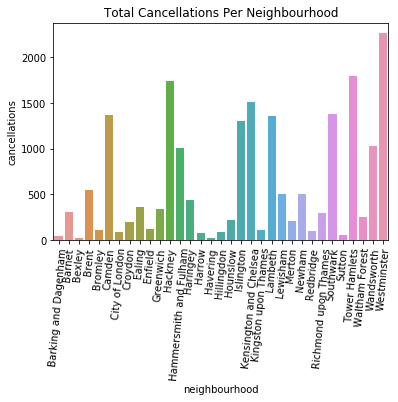

In [28]:
sns.barplot(x='neighbourhood',y='num_cancellations',data=df_g)
plt.ylabel('cancellations')
plt.xticks(rotation=85)
plt.title('Total Cancellations Per Neighbourhood')

In [29]:
print('Top 5 Neighborhoods with the most cancellations:')
df_g.sort_values(by=['num_cancellations'],ascending=False)[['neighbourhood','num_cancellations']][:5]

Top 5 Neighborhoods with the most cancellations:


,neighbourhood,num_cancellations
32,Westminster,2267.0
29,Tower Hamlets,1791.0
11,Hackney,1737.0
19,Kensington and Chelsea,1509.0
27,Southwark,1376.0


**We see that Westminister has the most number of cancellations but also has the most number of Airbnb listings, so looking at the total number of cancellations alone would not be a good metric. We need to take into account the listings each neighborhood has since it varies.**

Text(0.5, 1.0, 'Cancellations-Listing Ratio Per Neighbourhood')

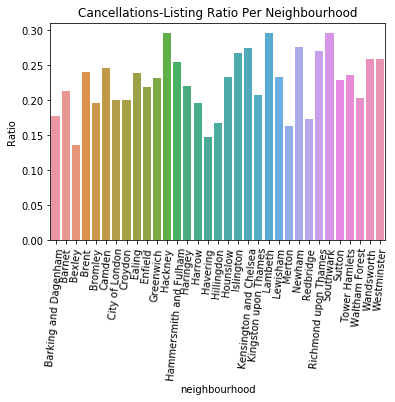

In [32]:
df_g['ratio']=df_g.num_cancellations/df_g.total_listings

sns.barplot(x='neighbourhood',y='ratio',data=df_g)
plt.ylabel('Ratio')
plt.xticks(rotation=85)
plt.title('Cancellations-Listing Ratio Per Neighbourhood')


**Is there a relationship between 'days booked' and 'num_cancellations'?**

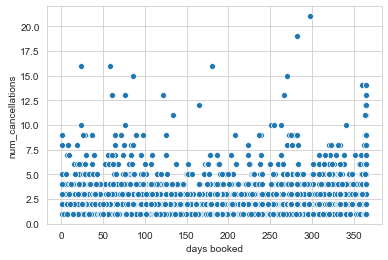

In [55]:
sns.set_style('whitegrid')
sns.scatterplot(x='days booked',y='num_cancellations',data=df)

**Does price correlate with these cancellations?**

(78074, 18)
(78052, 18)


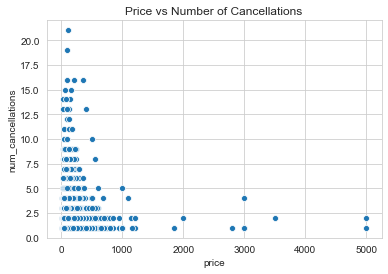

In [34]:
df_price=df[df.price!=0]
sns.set_style('whitegrid')
sns.scatterplot(x='price',y='num_cancellations',data=df_price)
plt.title('Price vs Number of Cancellations')

print(df.shape)
print(df_price.shape)

**Based on the room type, which neighborhoods are the most expensive?**

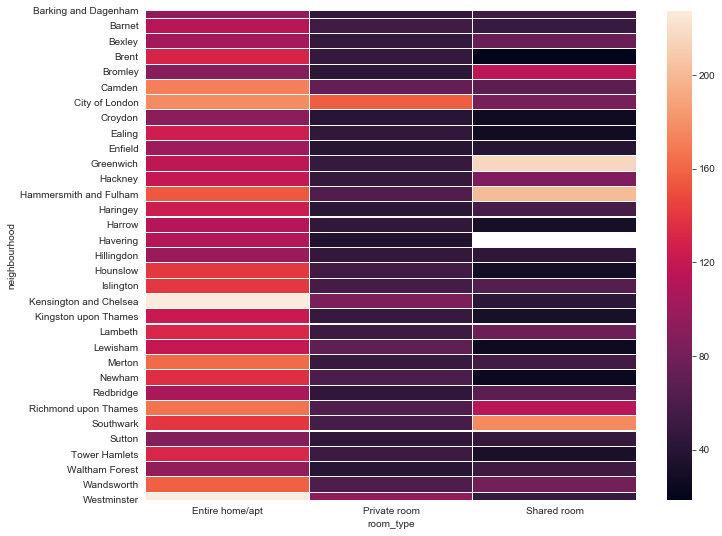

In [36]:
df_pivot=pd.pivot_table(df,values='price', index='neighbourhood',columns='room_type',aggfunc=np.mean)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_pivot,linewidths=.1,ax=ax)

**What was the room type of the listings cancelled the most?**

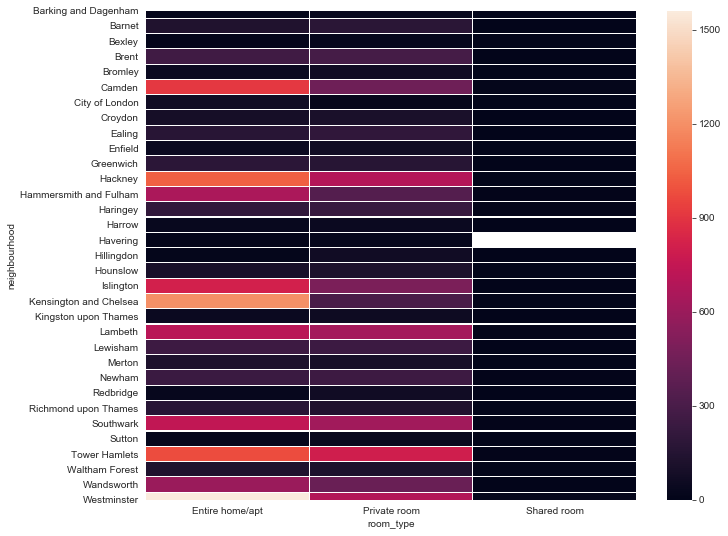

In [37]:
df_pivot2=pd.pivot_table(df,values='num_cancellations', index='neighbourhood',columns='room_type',aggfunc=np.sum)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_pivot2,linewidths=.1,ax=ax)

**Which neighborhoods have the highest crime rates?**

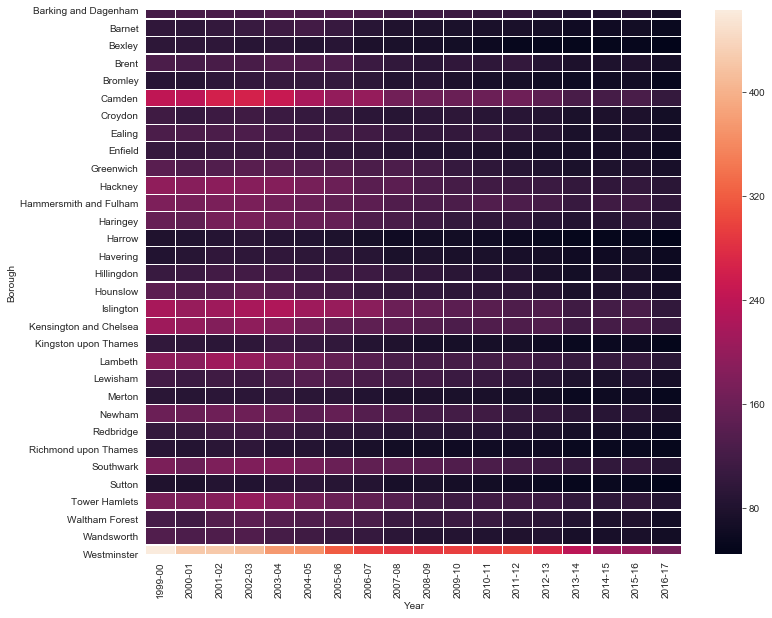

In [48]:
crime_p=pd.pivot_table(all_crimes,values='Rate', index='Borough',columns='Year',aggfunc=np.sum)

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(crime_p,linewidths=.1,ax=ax)

**Which neighborhood currently has the highest crime rate?**

Text(0.5, 1.0, 'Crime Rate Per Neighbourhood')

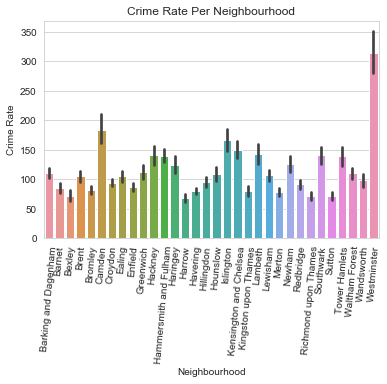

In [49]:
sns.barplot(x='Borough',y='Rate',data=all_crimes)
plt.ylabel('Crime Rate')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=85)
plt.title('Crime Rate Per Neighbourhood')

**Since the crime rates of all neighborhhds have decreased since 1990, we can just focus on the crime rates from 2011 (earliest Airbnb listing in our data) to 2017(latest crime rate data provided by the csv file)**

In [119]:
conv_fl = lambda x: int(x.replace('-',''))
year = all_crimes.Year.apply(conv_fl)
all_crimes['Year']=year

latest=all_crimes[(all_crimes['Year'])>=201112]
latest

,Code,Borough,Year,Offences,Rate,Number_of_offences
444,E09000002,Barking and Dagenham,201112,All recorded offences,100.7,18825.0
445,E09000003,Barnet,201112,All recorded offences,73.5,26281.0
446,E09000004,Bexley,201112,All recorded offences,52.3,12168.0
447,E09000005,Brent,201112,All recorded offences,101.2,31592.0
448,E09000006,Bromley,201112,All recorded offences,70.5,21903.0
...,...,...,...,...,...,...
656,E09000029,Sutton,201617,All recorded offences,45.0,9102.0
657,E09000030,Tower Hamlets,201617,All recorded offences,85.3,26005.0
658,E09000031,Waltham Forest,201617,All recorded offences,64.9,17899.0
659,E09000032,Wandsworth,201617,All recorded offences,65.8,20809.0


Text(0.5, 1.0, 'Crime Rate Per Neighbourhood 2016-17')

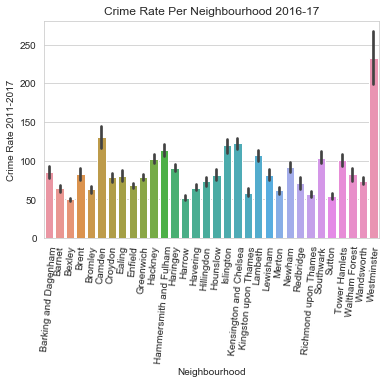

In [115]:
sns.barplot(x='Borough',y='Rate',data=latest)
plt.ylabel('Crime Rate 2011-2017')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=85)
plt.title('Crime Rate Per Neighbourhood 2016-17')

Text(0.5, 1.0, 'Crime Rate vs Number of Cancellations')

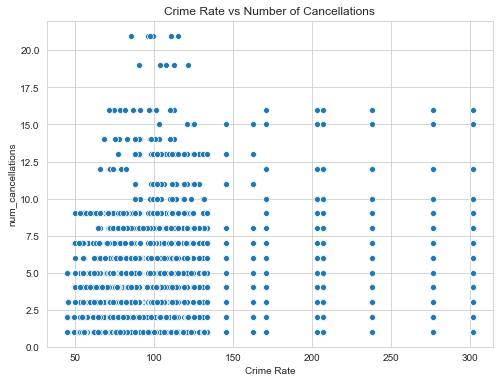

In [121]:

df_main=pd.merge(df,latest,left_on='neighbourhood',right_on='Borough',how='left').drop(['Code','Offences','Year','Borough'],axis=1)

f, ax = plt.subplots(figsize=(8,6))

sns.set_style('whitegrid')
sns.scatterplot(x='Rate',y='num_cancellations',data=df_main)
plt.xlabel('Crime Rate')
plt.title('Crime Rate vs Number of Cancellations')


Text(0.5, 1.0, 'Crime Rate vs Price')

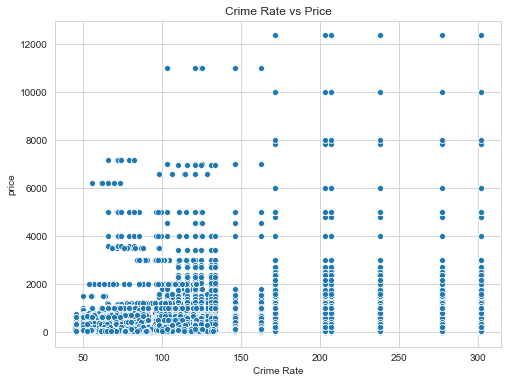

In [122]:
f, ax = plt.subplots(figsize=(8,6))

sns.set_style('whitegrid')
sns.scatterplot(x='Rate',y='price',data=df_main)
plt.xlabel('Crime Rate')
plt.title('Crime Rate vs Price')
